In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'})
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes, fontsize=10)

    ax.legend()

# Carregando arquivos Excel
excel_file1 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
excel_file2 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

# Lista de abas para a primeira tabela
abas_agua = ['Gravador 01', 'Gravador 04', 'Gravador 05', 'Gravador 06']

# Lista de abas para a segunda tabela
abas_bosque = ['Gravador 01', 'Gravador 03', 'Gravador 04', 'Gravador 06', 'Gravador 07', 'Gravador 09']

# Listas para armazenar os DataFrames de cada grupo
dfs_agua = []
dfs_bosque = []

# Carregando os DataFrames de cada aba da primeira tabela
for aba in abas_agua:
    df_temp = pd.read_excel(excel_file1, sheet_name=aba)
    df_temp['Tabela'] = 'Água'
    dfs_agua.append(df_temp)

# Carregando os DataFrames de cada aba da segunda tabela
for aba in abas_bosque:
    df_temp = pd.read_excel(excel_file2, sheet_name=aba)
    df_temp['Tabela'] = 'Bosque'
    dfs_bosque.append(df_temp)

# Concatenando todos os DataFrames em um único DataFrame para cada grupo
df_agua_concatenado = pd.concat(dfs_agua, ignore_index=True)
df_bosque_concatenado = pd.concat(dfs_bosque, ignore_index=True)

# Convertendo a coluna de Data para o formato de data
df_agua_concatenado['Data'] = pd.to_datetime(df_agua_concatenado['Data'], format='%d/%m/%y')
df_bosque_concatenado['Data'] = pd.to_datetime(df_bosque_concatenado['Data'], format='%d/%m/%y')

# Filtrando vocalizações 'trill adulto' sem fazer a média diária
limite_duracao = 0.0
dados_filtrados_agua = df_agua_concatenado[(df_agua_concatenado['Classificacao'] == 'phee adulto') & (df_agua_concatenado['Tempototal'] >= limite_duracao)].copy()
dados_filtrados_bosque = df_bosque_concatenado[(df_bosque_concatenado['Classificacao'] == 'phee adulto') & (df_bosque_concatenado['Tempototal'] >= limite_duracao)].copy()

# Filtrando vocalizações 'trill adulto' sem fazer a média diária
dados_filtrados_agua_trill = df_agua_concatenado[(df_agua_concatenado['Classificacao'] == 'trill adulto') & (df_agua_concatenado['Tempototal'] >= limite_duracao)].copy()
dados_filtrados_bosque_trill = df_bosque_concatenado[(df_bosque_concatenado['Classificacao'] == 'trill adulto') & (df_bosque_concatenado['Tempototal'] >= limite_duracao)].copy()

# Carregando os dados de temperatura
caminho_arquivo_temperatura = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Temperatura1.xlsx'
df_temperatura = pd.read_excel(caminho_arquivo_temperatura)

# Definindo o limite máximo para a filtragem (por exemplo, 50)
limite_maximo = 50

# Filtrando os dados de temperatura abaixo do limite máximo
df_temperatura_filtrada = df_temperatura[df_temperatura['Chuva'] <= limite_maximo]

# Filtrando os dados com base nas condições de latitude, longitude e temperatura não nula
filtro_temperatura = (df_temperatura['latitude'] == -5.5) & (df_temperatura['longitude'] == -37) & df_temperatura_filtrada['Chuva'].notna()

# Extraindo apenas a parte da data da coluna 'DataHora'
df_temperatura['DataHora'] = pd.to_datetime(df_temperatura['DataHora'])
df_temperatura['Data'] = df_temperatura['DataHora'].dt.date

# Filtrando os dias existentes na tabela de vocalizações
dias_vocalizacoes_agua = dados_filtrados_agua['Data'].dt.date.unique()
dias_vocalizacoes_bosque = dados_filtrados_bosque['Data'].dt.date.unique()

# Filtrando os dias desejados corretamente (de agosto de 2022 a julho de 2023)
resultados_temperatura = df_temperatura[filtro_temperatura & df_temperatura['Data'].isin(dias_vocalizacoes_agua) & df_temperatura['Data'].isin(dias_vocalizacoes_bosque)]

# Criando DataFrame para a média diária da temperatura
media_diaria_temperatura = resultados_temperatura.groupby('Data')['Chuva'].mean().reset_index()

# Certifique-se de que a coluna 'Data' está no formato datetime64[ns] em ambos os DataFrames
dados_filtrados_agua['Data'] = pd.to_datetime(dados_filtrados_agua['Data'])
dados_filtrados_bosque['Data'] = pd.to_datetime(dados_filtrados_bosque['Data'])
dados_filtrados_agua_trill['Data'] = pd.to_datetime(dados_filtrados_agua_trill['Data'])
dados_filtrados_bosque_trill['Data'] = pd.to_datetime(dados_filtrados_bosque_trill['Data'])
media_diaria_temperatura['Data'] = pd.to_datetime(media_diaria_temperatura['Data'])

# Agora você pode mesclar as tabelas sem problemas
df_final_dia_agua = pd.merge(dados_filtrados_agua, media_diaria_temperatura, on='Data', how='left')
df_final_dia_bosque = pd.merge(dados_filtrados_bosque, media_diaria_temperatura, on='Data', how='left')

# Mesclando com a temperatura média diária
df_final_dia_agua_trill = pd.merge(dados_filtrados_agua_trill, media_diaria_temperatura, on='Data', how='left')
df_final_dia_bosque_trill = pd.merge(dados_filtrados_bosque_trill, media_diaria_temperatura, on='Data', how='left')

# Criando coluna 'Estação' com base no mês
df_final_dia_agua['Estação'] = df_final_dia_agua['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')
df_final_dia_bosque['Estação'] = df_final_dia_bosque['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')

# Criando coluna 'Estação' com base no mês para 'trill adulto'
df_final_dia_agua_trill['Estação'] = df_final_dia_agua_trill['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')
df_final_dia_bosque_trill['Estação'] = df_final_dia_bosque_trill['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')
# Agora você pode usar df_final_dia_agua e df_final_dia_bosque para criar seus gráficos



C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\681701156.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\681701156.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\681701156.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\681701156.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

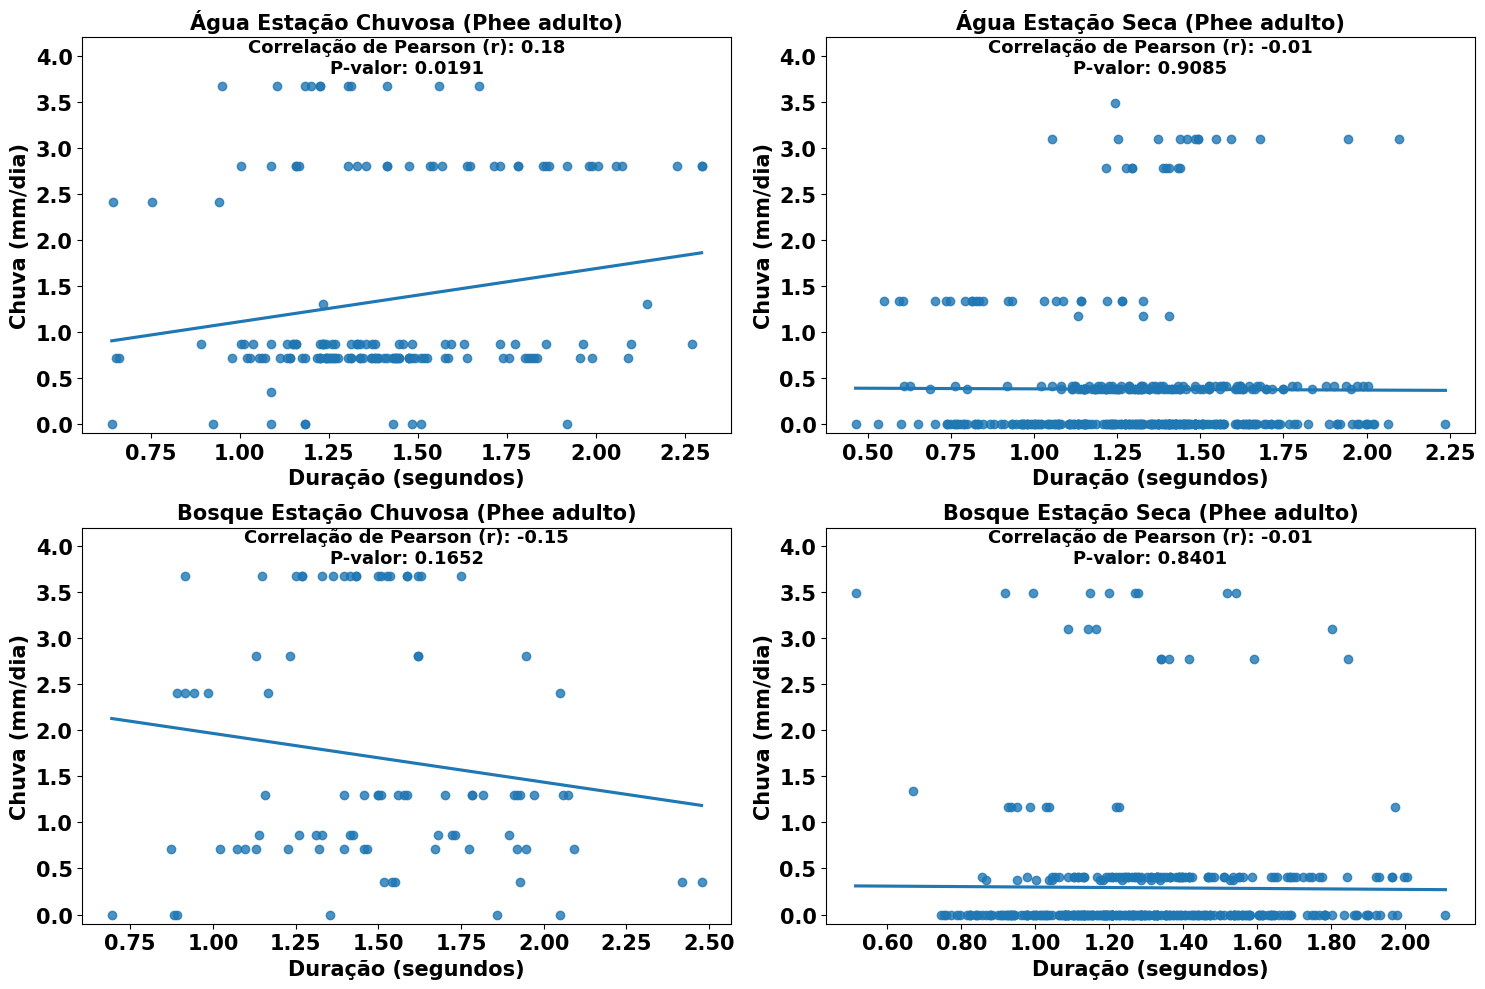

In [37]:
# print(df_final_dia_agua)
# print(df_final_dia_bosque)
# # Mesclando os DataFrames por Data, mantendo apenas as datas comuns aos dois
# df_comum = pd.merge(df_final_dia_agua[['Data', 'Tempototal']], 
#                     df_final_dia_bosque[['Data', 'Tempototal']], 
#                     on='Data', 
#                     suffixes=('_agua', '_bosque'))

# # Verificando se o DataFrame resultante não está vazio
# if df_comum.empty:
#     print("A mesclagem resultou em um DataFrame vazio. Verifique as datas.")
# else:
#     print("Mesclagem realizada com sucesso! A seguir estão as primeiras linhas do DataFrame resultante:")
#     print(df_comum.head())

from matplotlib.ticker import FormatStrFormatter
import numpy as np 
# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, ci=None)
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes,weight="bold", fontsize=13)

    # ax.legend()

# Criando figuras e eixos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Definindo o número desejado de ticks para o eixo x
num_ticks = 4

# Subplot 1: Regressão para o Grupo Água na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Chuvosa']['Chuva'],
    axes[0, 0],
    'Água - Estação Chuvosa'
)
axes[0, 0].set_title(f'Água Estação Chuvosa (Phee adulto)', size=15, weight="bold")
axes[0, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 0].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
    # axes[0, 0].set_xticks(np.linspace(axes[0, 0].get_xlim()[0], axes[0, 0].get_xlim()[1], num_ticks))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='x', labelsize=15)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='y', labelsize=15)
axes[0, 0].set_ylim(-0.1, 4.2)


# Subplot 2: Regressão para o Grupo Água na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Seca']['Chuva'],
    axes[0, 1],
    'Água - Estação Seca'
)
axes[0, 1].set_title(f'Água Estação Seca (Phee adulto)', size=15, weight="bold")
axes[0, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 1].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
axes[0, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='x', labelsize=15)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticks(), fontweight="bold")
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='y', labelsize=15)
axes[0, 1].set_ylim(-0.1, 4.2)

# Subplot 3: Regressão para o Grupo Bosque na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Chuvosa']['Chuva'],
    axes[1, 0],
    'Bosque - Estação Chuvosa'
)
axes[1, 0].set_title(f'Bosque Estação Chuvosa (Phee adulto)', size=15, weight="bold")
axes[1, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 0].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='x', labelsize=15)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticks(), fontweight="bold")
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='y', labelsize=15)
axes[1, 0].set_ylim(-0.1, 4.2)

# Subplot 4: Regressão para o Grupo Bosque na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Seca']['Chuva'],
    axes[1, 1],
    'Bosque - Estação Seca'
)
axes[1, 1].set_title(f'Bosque Estação Seca (Phee adulto)', size=15, weight="bold")
axes[1, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 1].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='x', labelsize=15)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='y', labelsize=15)
axes[1, 1].set_ylim(-0.1, 4.2)
# axes[1, 1].set_xlim(0.45, 0.9)
# Ajustando o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação_dia_pheeadulto_chuva_estações.png', bbox_inches='tight')

plt.show()

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\2653703490.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\2653703490.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\2653703490.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_6896\2653703490.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or us

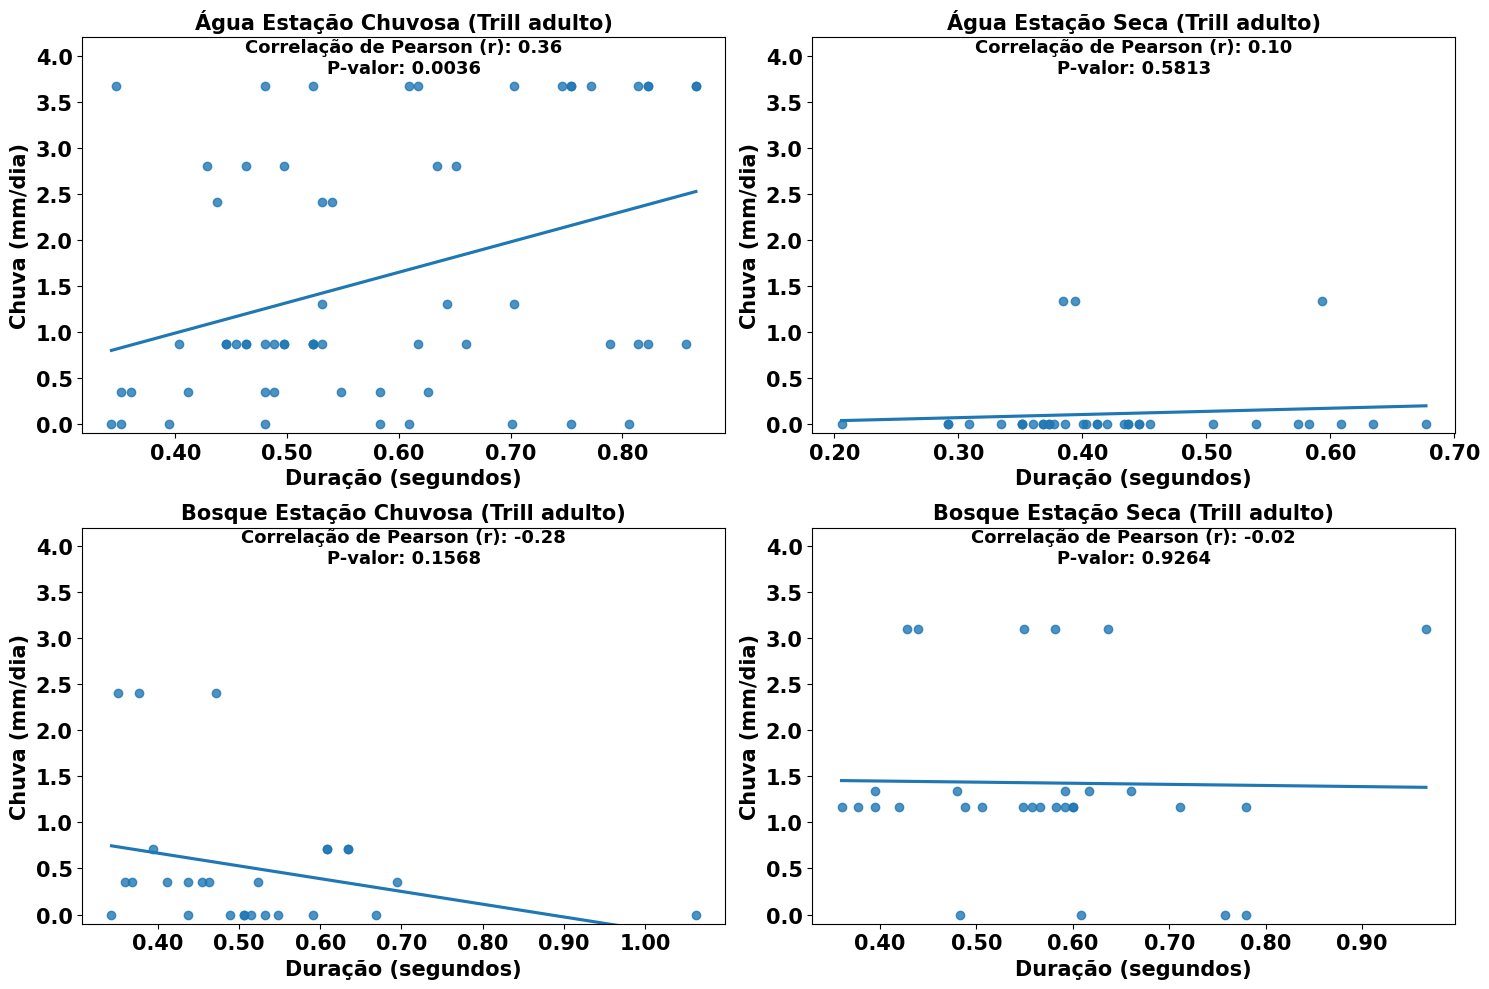

In [39]:
from matplotlib.ticker import FormatStrFormatter
import numpy as np 
# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, ci=None)
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes,weight="bold", fontsize=13)

    # ax.legend()

# Criando figuras e eixos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Definindo o número desejado de ticks para o eixo x
num_ticks = 4

# Subplot 1: Regressão para o Grupo Água na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Chuvosa']['Chuva'],
    axes[0, 0],
    'Água - Estação Chuvosa'
)
axes[0, 0].set_title(f'Água Estação Chuvosa (Trill adulto)', size=15, weight="bold")
axes[0, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 0].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
    # axes[0, 0].set_xticks(np.linspace(axes[0, 0].get_xlim()[0], axes[0, 0].get_xlim()[1], num_ticks))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='x', labelsize=15)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='y', labelsize=15)
axes[0, 0].set_ylim(-0.1, 4.2)


# Subplot 2: Regressão para o Grupo Água na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Seca']['Chuva'],
    axes[0, 1],
    'Água - Estação Seca'
)
axes[0, 1].set_title(f'Água Estação Seca (Trill adulto)', size=15, weight="bold")
axes[0, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 1].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
axes[0, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='x', labelsize=15)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticks(), fontweight="bold")
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='y', labelsize=15)
axes[0, 1].set_ylim(-0.1, 4.2)

# Subplot 3: Regressão para o Grupo Bosque na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Chuvosa']['Chuva'],
    axes[1, 0],
    'Bosque - Estação Chuvosa'
)
axes[1, 0].set_title(f'Bosque Estação Chuvosa (Trill adulto)', size=15, weight="bold")
axes[1, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 0].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='x', labelsize=15)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticks(), fontweight="bold")
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='y', labelsize=15)
axes[1, 0].set_ylim(-0.1, 4.2)

# Subplot 4: Regressão para o Grupo Bosque na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Seca']['Chuva'],
    axes[1, 1],
    'Bosque - Estação Seca'
)
axes[1, 1].set_title(f'Bosque Estação Seca (Trill adulto)', size=15, weight="bold")
axes[1, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 1].set_ylabel('Chuva (mm/dia)', size=15, weight="bold")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='x', labelsize=15)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='y', labelsize=15)
axes[1, 1].set_ylim(-0.1, 4.2)
# axes[1, 1].set_xlim(0.45, 0.9)
# Ajustando o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação_dia_trilladulto_chuva_estações.png', bbox_inches='tight')

plt.show()

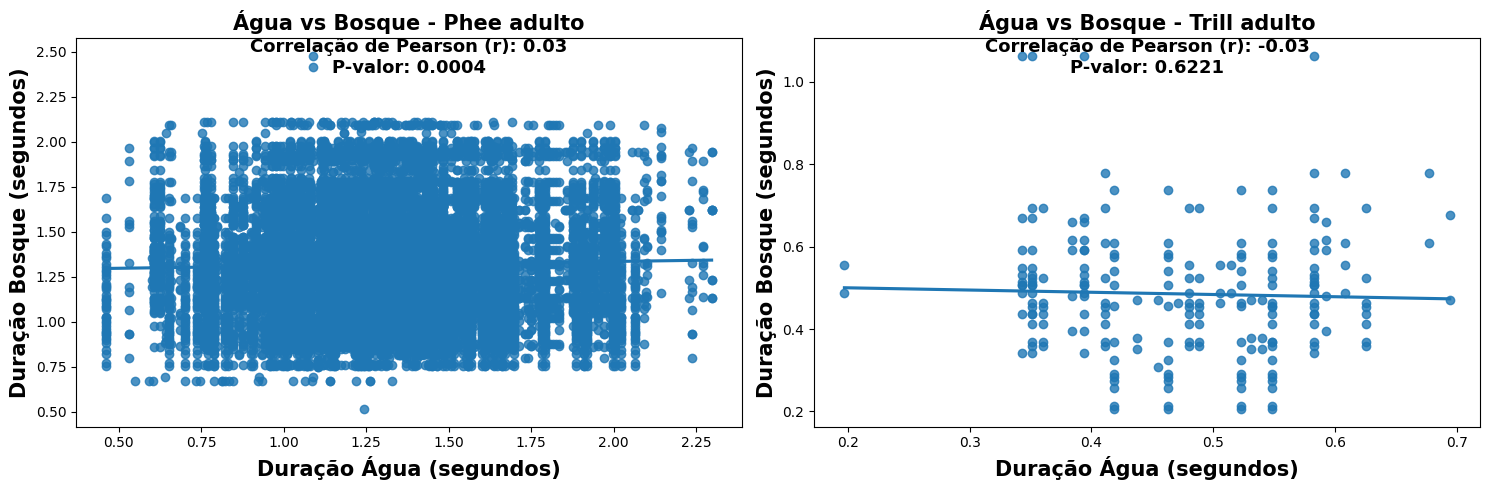

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr
from matplotlib.ticker import FormatStrFormatter

# Carregamento dos arquivos Excel
excel_file1 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
excel_file2 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

# Lista de abas para a primeira tabela
abas_agua = ['Gravador 01', 'Gravador 04', 'Gravador 05', 'Gravador 06']

# Lista de abas para a segunda tabela
abas_bosque = ['Gravador 01', 'Gravador 03', 'Gravador 04', 'Gravador 06', 'Gravador 07', 'Gravador 09']

# Carregando os DataFrames de cada aba da primeira tabela
df_agua = [pd.read_excel(excel_file1, sheet_name=aba) for aba in abas_agua]
for df in df_agua:
    df['Tabela'] = 'Água'

# Carregando os DataFrames de cada aba da segunda tabela
df_bosque = [pd.read_excel(excel_file2, sheet_name=aba) for aba in abas_bosque]
for df in df_bosque:
    df['Tabela'] = 'Bosque'

# Concatenando todos os dataframes em um único dataframe
combined_df_agua = pd.concat(df_agua, ignore_index=True)
combined_df_bosque = pd.concat(df_bosque, ignore_index=True)

# Convertendo a coluna de Data para o formato de data
combined_df_agua['Data'] = pd.to_datetime(combined_df_agua['Data'], format='%d/%m/%y')
combined_df_bosque['Data'] = pd.to_datetime(combined_df_bosque['Data'], format='%d/%m/%y')

# Criando uma coluna 'Dia' para armazenar o dia de cada data
combined_df_agua['Dia'] = combined_df_agua['Data'].dt.date
combined_df_bosque['Dia'] = combined_df_bosque['Data'].dt.date

# Filtro para vocalizações 'phee' e 'trill'
tsik_data_agua = combined_df_agua[combined_df_agua['Classificacao'].isin(['phee adulto', 'trill adulto'])].copy()
tsik_data_bosque = combined_df_bosque[combined_df_bosque['Classificacao'].isin(['phee adulto', 'trill adulto'])].copy()

# Fazer o merge para pegar apenas os dias presentes em ambos os grupos
df_merged = pd.merge(tsik_data_agua, tsik_data_bosque, on='Dia', suffixes=('_agua', '_bosque'))

# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, ci=None)
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes,weight="bold", fontsize=13)

# Criar figura e eixos
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Subplot 1: Regressão para Grupo Água e Bosque - 'phee'
phee_data_agua = df_merged[df_merged['Classificacao_agua'] == 'phee adulto']['Tempototal_agua']
phee_data_bosque = df_merged[df_merged['Classificacao_bosque'] == 'phee adulto']['Tempototal_bosque']

plot_regressao_com_r2_correlacao_pvalor(
    phee_data_agua,
    phee_data_bosque,
    axes[0],
    'Água vs Bosque (phee)'
)

# Subplot 2: Regressão para Grupo Água e Bosque - 'trill'
trill_data_agua = df_merged[df_merged['Classificacao_agua'] == 'trill adulto']['Tempototal_agua']
trill_data_bosque = df_merged[df_merged['Classificacao_bosque'] == 'trill adulto']['Tempototal_bosque']

plot_regressao_com_r2_correlacao_pvalor(
    trill_data_agua,
    trill_data_bosque,
    axes[1],
    'Água vs Bosque (trill)'
)

# Ajustar títulos e labels
axes[0].set_title(f'Água vs Bosque - Phee adulto', size=15, weight="bold")
axes[0].set_xlabel('Duração Água (segundos)', size=15, weight="bold")
axes[0].set_ylabel('Duração Bosque (segundos)', size=15, weight="bold")

axes[1].set_title(f'Água vs Bosque - Trill adulto', size=15, weight="bold")
axes[1].set_xlabel('Duração Água (segundos)', size=15, weight="bold")
axes[1].set_ylabel('Duração Bosque (segundos)', size=15, weight="bold")

# Ajustar o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlacao_agua_bosque_phee_trill.png', bbox_inches='tight')
plt.show()


C:\Users\Ricardo\AppData\Local\Temp\ipykernel_7264\2727485473.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_7264\2727485473.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_7264\2727485473.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_7264\2727485473.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after 

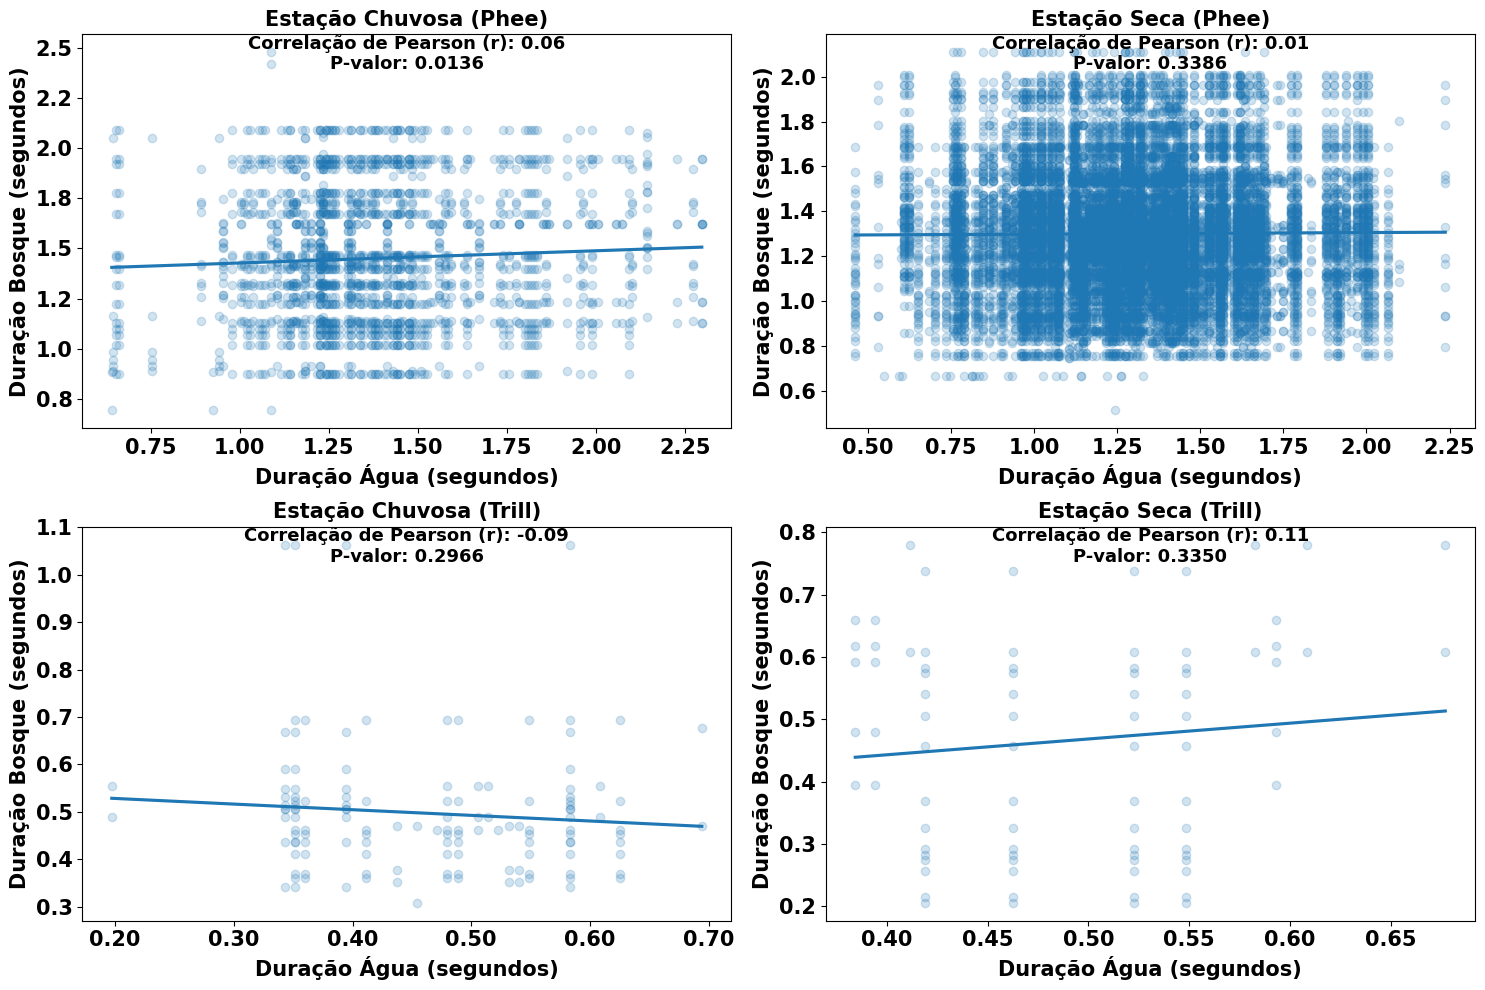

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr
from matplotlib.ticker import FormatStrFormatter

# Carregamento dos arquivos Excel
excel_file1 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
excel_file2 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

# Lista de abas para a primeira tabela
abas_agua = ['Gravador 01', 'Gravador 04', 'Gravador 05', 'Gravador 06']

# Lista de abas para a segunda tabela
abas_bosque = ['Gravador 01', 'Gravador 03', 'Gravador 04', 'Gravador 06', 'Gravador 07', 'Gravador 09']

# Carregando os DataFrames de cada aba da primeira tabela
df_agua = [pd.read_excel(excel_file1, sheet_name=aba) for aba in abas_agua]
for df in df_agua:
    df['Tabela'] = 'Água'

# Carregando os DataFrames de cada aba da segunda tabela
df_bosque = [pd.read_excel(excel_file2, sheet_name=aba) for aba in abas_bosque]
for df in df_bosque:
    df['Tabela'] = 'Bosque'

# Concatenando todos os dataframes em um único dataframe
combined_df_agua = pd.concat(df_agua, ignore_index=True)
combined_df_bosque = pd.concat(df_bosque, ignore_index=True)

# Convertendo a coluna de Data para o formato de data
combined_df_agua['Data'] = pd.to_datetime(combined_df_agua['Data'], format='%d/%m/%y')
combined_df_bosque['Data'] = pd.to_datetime(combined_df_bosque['Data'], format='%d/%m/%y')

# Criando uma coluna 'Dia' para armazenar o dia de cada data
combined_df_agua['Dia'] = combined_df_agua['Data'].dt.date
combined_df_bosque['Dia'] = combined_df_bosque['Data'].dt.date

# Criando coluna 'Estação' com base no mês
combined_df_agua['Estação'] = combined_df_agua['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')
combined_df_bosque['Estação'] = combined_df_bosque['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')

# Filtro para vocalizações 'phee' e 'trill'
tsik_data_agua = combined_df_agua[combined_df_agua['Classificacao'].isin(['phee adulto', 'trill adulto'])].copy()
tsik_data_bosque = combined_df_bosque[combined_df_bosque['Classificacao'].isin(['phee adulto', 'trill adulto'])].copy()

# Fazer o merge para pegar apenas os dias presentes em ambos os grupos
df_merged = pd.merge(tsik_data_agua, tsik_data_bosque, on=['Dia', 'Estação'], suffixes=('_agua', '_bosque'))

def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão com pontos transparentes
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, 
                line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, 
                ci=None, scatter_kws={'alpha': 0.2})  # Adicionei alpha aqui

    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', 
            ha='center', va='center', transform=ax.transAxes, weight="bold", fontsize=13)

# Criar figura e eixos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Subplot 1: Regressão para Grupo Água e Bosque - 'phee' na estação Chuvosa
phee_chuvosa_agua = df_merged[(df_merged['Classificacao_agua'] == 'phee adulto') & (df_merged['Estação'] == 'Chuvosa')]['Tempototal_agua']
phee_chuvosa_bosque = df_merged[(df_merged['Classificacao_bosque'] == 'phee adulto') & (df_merged['Estação'] == 'Chuvosa')]['Tempototal_bosque']

plot_regressao_com_r2_correlacao_pvalor(
    phee_chuvosa_agua,
    phee_chuvosa_bosque,
    axes[0, 0],
    'Água vs Bosque - Phee Chuvosa'
)

# Subplot 2: Regressão para Grupo Água e Bosque - 'phee' na estação Seca
phee_seca_agua = df_merged[(df_merged['Classificacao_agua'] == 'phee adulto') & (df_merged['Estação'] == 'Seca')]['Tempototal_agua']
phee_seca_bosque = df_merged[(df_merged['Classificacao_bosque'] == 'phee adulto') & (df_merged['Estação'] == 'Seca')]['Tempototal_bosque']

plot_regressao_com_r2_correlacao_pvalor(
    phee_seca_agua,
    phee_seca_bosque,
    axes[0, 1],
    'Água vs Bosque - Phee Seca'
)

# Subplot 3: Regressão para Grupo Água e Bosque - 'trill' na estação Chuvosa
trill_chuvosa_agua = df_merged[(df_merged['Classificacao_agua'] == 'trill adulto') & (df_merged['Estação'] == 'Chuvosa')]['Tempototal_agua']
trill_chuvosa_bosque = df_merged[(df_merged['Classificacao_bosque'] == 'trill adulto') & (df_merged['Estação'] == 'Chuvosa')]['Tempototal_bosque']

plot_regressao_com_r2_correlacao_pvalor(
    trill_chuvosa_agua,
    trill_chuvosa_bosque,
    axes[1, 0],
    'Água vs Bosque - Trill Chuvosa'
)

# Subplot 4: Regressão para Grupo Água e Bosque - 'trill' na estação Seca
trill_seca_agua = df_merged[(df_merged['Classificacao_agua'] == 'trill adulto') & (df_merged['Estação'] == 'Seca')]['Tempototal_agua']
trill_seca_bosque = df_merged[(df_merged['Classificacao_bosque'] == 'trill adulto') & (df_merged['Estação'] == 'Seca')]['Tempototal_bosque']

plot_regressao_com_r2_correlacao_pvalor(
    trill_seca_agua,
    trill_seca_bosque,
    axes[1, 1],
    'Água vs Bosque - Trill Seca'
)

# Ajustar títulos e labels
axes[0, 0].set_title(f'Estação Chuvosa (Phee)', size=15, weight="bold")
axes[0, 0].set_xlabel('Duração Água (segundos)', size=15, weight="bold")
axes[0, 0].set_ylabel('Duração Bosque (segundos)', size=15, weight="bold")
axes[0, 0].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='x', labelsize=15)
axes[0, 0].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='y', labelsize=15)
# axes[0, 0].set_ylim(26, 31)

axes[0, 1].set_title(f'Estação Seca (Phee)', size=15, weight="bold")
axes[0, 1].set_xlabel('Duração Água (segundos)', size=15, weight="bold")
axes[0, 1].set_ylabel('Duração Bosque (segundos)', size=15, weight="bold")
axes[0, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='x', labelsize=15)
axes[0, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='y', labelsize=15)
# axes[0, 1].set_ylim(26, 31)

axes[1, 0].set_title(f'Estação Chuvosa (Trill)', size=15, weight="bold")
axes[1, 0].set_xlabel('Duração Água (segundos)', size=15, weight="bold")
axes[1, 0].set_ylabel('Duração Bosque (segundos)', size=15, weight="bold")
axes[1, 0].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='x', labelsize=15)
axes[1, 0].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='y', labelsize=15)
# axes[1, 0].set_ylim(26, 31)

axes[1, 1].set_title(f'Estação Seca (Trill)', size=15, weight="bold")
axes[1, 1].set_xlabel('Duração Água (segundos)',size=15, weight="bold")
axes[1, 1].set_ylabel('Duração Bosque (segundos)', size=15, weight="bold")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='x', labelsize=15)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='y', labelsize=15)
# axes[1, 1].set_ylim(26, 31)
# Ajustar o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlacao_agua_bosque_estacoes.png', bbox_inches='tight')
plt.show()


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'})
    
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes, fontsize=10)

    ax.legend()

# Carregando os arquivos Excel
excel_file1 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Agua_bb_adulto.xlsx'
excel_file2 = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Bosque_bb_adulto.xlsx'

abas_agua = ['Gravador 01', 'Gravador 04', 'Gravador 05', 'Gravador 06']
abas_bosque = ['Gravador 01', 'Gravador 03', 'Gravador 04', 'Gravador 06', 'Gravador 07', 'Gravador 09']

dfs_agua = []
dfs_bosque = []

for aba in abas_agua:
    df_temp = pd.read_excel(excel_file1, sheet_name=aba)
    df_temp['Tabela'] = 'Água'
    dfs_agua.append(df_temp)

for aba in abas_bosque:
    df_temp = pd.read_excel(excel_file2, sheet_name=aba)
    df_temp['Tabela'] = 'Bosque'
    dfs_bosque.append(df_temp)

df_agua_concatenado = pd.concat(dfs_agua, ignore_index=True)
df_bosque_concatenado = pd.concat(dfs_bosque, ignore_index=True)

df_agua_concatenado['Data'] = pd.to_datetime(df_agua_concatenado['Data'], format='%d/%m/%y').dt.date
df_bosque_concatenado['Data'] = pd.to_datetime(df_bosque_concatenado['Data'], format='%d/%m/%y').dt.date

limite_duracao = 0.0
dados_filtrados_agua = df_agua_concatenado[(df_agua_concatenado['Classificacao'] == 'phee adulto') & (df_agua_concatenado['Tempototal'] >= limite_duracao)].copy()
dados_filtrados_bosque = df_bosque_concatenado[(df_bosque_concatenado['Classificacao'] == 'phee adulto') & (df_bosque_concatenado['Tempototal'] >= limite_duracao)].copy()

dados_filtrados_agua_trill = df_agua_concatenado[(df_agua_concatenado['Classificacao'] == 'trill adulto') & (df_agua_concatenado['Tempototal'] >= limite_duracao)].copy()
dados_filtrados_bosque_trill = df_bosque_concatenado[(df_bosque_concatenado['Classificacao'] == 'trill adulto') & (df_bosque_concatenado['Tempototal'] >= limite_duracao)].copy()

# Carregando os dados de temperatura
caminho_arquivo_temperatura = r'C:\Users\Ricardo\Desktop\Tabelas_grupos\Temperatura e chuva.xlsx'
df_temperatura = pd.read_excel(caminho_arquivo_temperatura)

df_temperatura['DataHora'] = pd.to_datetime(df_temperatura['DataHora'])
df_temperatura['Data'] = df_temperatura['DataHora'].dt.date
df_temperatura['Hora'] = df_temperatura['DataHora'].dt.time

# Arredondando a hora das vocalizações para a hora cheia anterior
dados_filtrados_agua['HoraArredondada'] = dados_filtrados_agua['Hora'].apply(lambda x: x.replace(minute=0, second=0))
dados_filtrados_bosque['HoraArredondada'] = dados_filtrados_bosque['Hora'].apply(lambda x: x.replace(minute=0, second=0))
dados_filtrados_agua_trill['HoraArredondada'] = dados_filtrados_agua_trill['Hora'].apply(lambda x: x.replace(minute=0, second=0))
dados_filtrados_bosque_trill['HoraArredondada'] = dados_filtrados_bosque_trill['Hora'].apply(lambda x: x.replace(minute=0, second=0))

# Converte a coluna 'Hora' no DataFrame de temperatura para datetime.time
df_temperatura['Hora'] = df_temperatura['DataHora'].dt.time


# Mesclando os DataFrames com base na data e hora arredondada
df_final_dia_agua = pd.merge(dados_filtrados_agua, df_temperatura, left_on=['Data', 'HoraArredondada'], right_on=['Data', 'Hora'], how='left')
df_final_dia_bosque = pd.merge(dados_filtrados_bosque, df_temperatura, left_on=['Data', 'HoraArredondada'], right_on=['Data', 'Hora'], how='left')

df_final_dia_agua_trill = pd.merge(dados_filtrados_agua_trill, df_temperatura, left_on=['Data', 'HoraArredondada'], right_on=['Data', 'Hora'], how='left')
df_final_dia_bosque_trill = pd.merge(dados_filtrados_bosque_trill, df_temperatura, left_on=['Data', 'HoraArredondada'], right_on=['Data', 'Hora'], how='left')

# Criando a coluna 'Estação' com base no mês
df_final_dia_agua['Estação'] = df_final_dia_agua['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')
df_final_dia_bosque['Estação'] = df_final_dia_bosque['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')

df_final_dia_agua_trill['Estação'] = df_final_dia_agua_trill['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')
df_final_dia_bosque_trill['Estação'] = df_final_dia_bosque_trill['Data'].apply(lambda x: 'Chuvosa' if 2 <= x.month <= 7 else 'Seca')

# Agora você pode usar os DataFrames df_final_dia_agua e df_final_dia_bosque com as temperaturas por horário.


C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\1457797339.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\1457797339.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\1457797339.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\1457797339.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

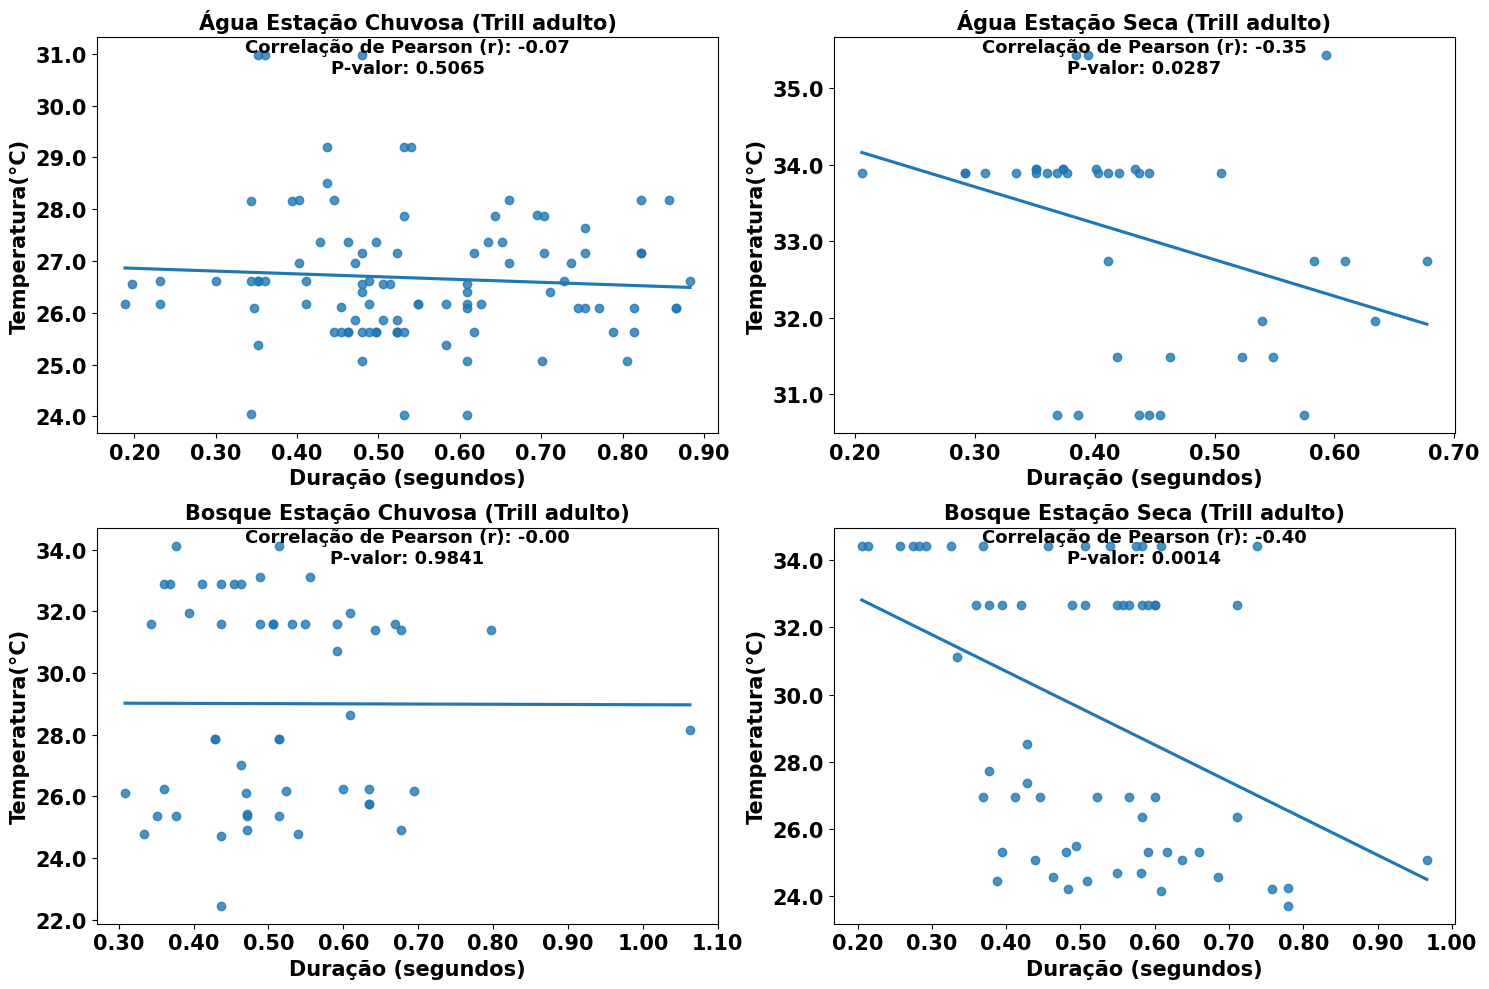

In [8]:
from matplotlib.ticker import FormatStrFormatter
import numpy as np 
# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, ci=None)
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes,weight="bold", fontsize=13)

    # ax.legend()

# Criando figuras e eixos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Definindo o número desejado de ticks para o eixo x
num_ticks = 4

# Subplot 1: Regressão para o Grupo Água na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Chuvosa']['Temperatura'],
    axes[0, 0],
    'Água - Estação Chuvosa'
)
axes[0, 0].set_title(f'Água Estação Chuvosa (Trill adulto)', size=15, weight="bold")
axes[0, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 0].set_ylabel('Temperatura(°C)', size=15, weight="bold")
    # axes[0, 0].set_xticks(np.linspace(axes[0, 0].get_xlim()[0], axes[0, 0].get_xlim()[1], num_ticks))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='x', labelsize=15)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='y', labelsize=15)
# axes[0, 0].set_ylim(26, 31)


# Subplot 2: Regressão para o Grupo Água na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_agua_trill[df_final_dia_agua_trill['Estação'] == 'Seca']['Temperatura'],
    axes[0, 1],
    'Água - Estação Seca'
)
axes[0, 1].set_title(f'Água Estação Seca (Trill adulto)', size=15, weight="bold")
axes[0, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 1].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
axes[0, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='x', labelsize=15)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticks(), fontweight="bold")
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='y', labelsize=15)
# axes[0, 1].set_ylim(26, 31)

# Subplot 3: Regressão para o Grupo Bosque na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Chuvosa']['Temperatura'],
    axes[1, 0],
    'Bosque - Estação Chuvosa'
)
axes[1, 0].set_title(f'Bosque Estação Chuvosa (Trill adulto)', size=15, weight="bold")
axes[1, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 0].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='x', labelsize=15)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticks(), fontweight="bold")
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='y', labelsize=15)
# axes[1, 0].set_ylim(26, 31)

# Subplot 4: Regressão para o Grupo Bosque na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_bosque_trill[df_final_dia_bosque_trill['Estação'] == 'Seca']['Temperatura'],
    axes[1, 1],
    'Bosque - Estação Seca'
)
axes[1, 1].set_title(f'Bosque Estação Seca (Trill adulto)', size=15, weight="bold")
axes[1, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 1].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='x', labelsize=15)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='y', labelsize=15)
# axes[1, 1].set_ylim(26, 31)
# axes[1, 1].set_xlim(0.45, 0.9)
# Ajustando o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação_dia_trilladulto_temperatura_estações.png', bbox_inches='tight')

plt.show()

Água - Estação Chuvosa - P-valor: 0.00018287109175835016
Água - Estação Seca - P-valor: 4.355806941047084e-10
Bosque - Estação Chuvosa - P-valor: 1.1459852240840654e-16
Bosque - Estação Seca - P-valor: 0.020882532109172264


C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\792337126.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\792337126.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\792337126.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\792337126.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or us

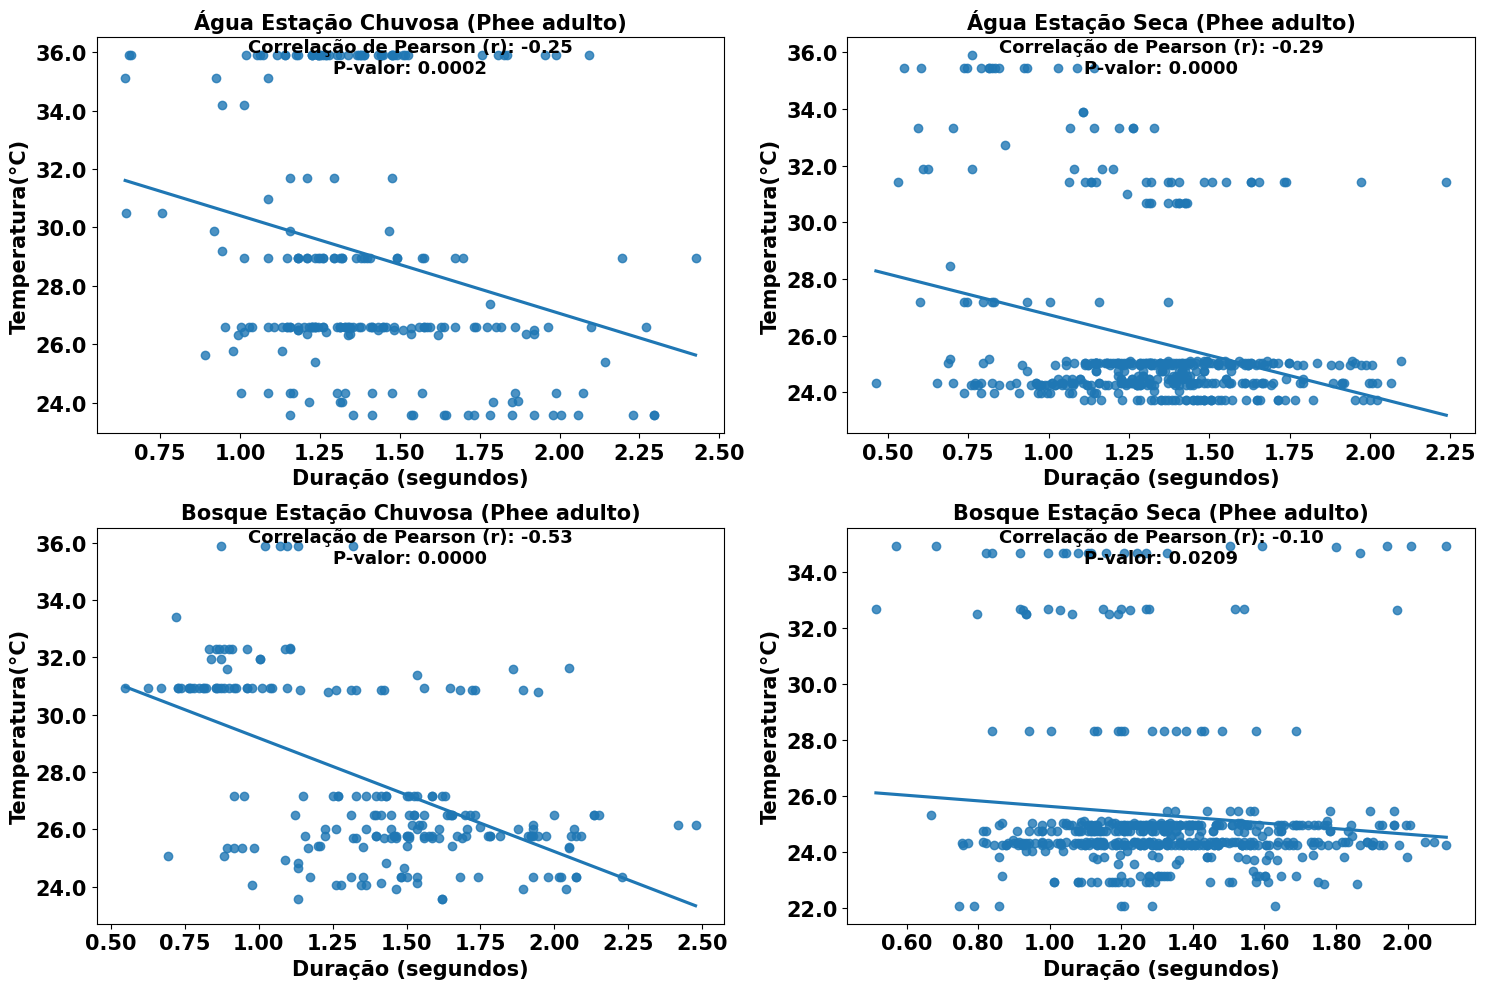

In [7]:
from matplotlib.ticker import FormatStrFormatter
import numpy as np 
# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, ci=None)
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes,weight="bold", fontsize=13)

 # Imprimindo o p-valor no console
    print(f'{grupo} - P-valor: {p_val}')

# Criando figuras e eixos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Definindo o número desejado de ticks para o eixo x
num_ticks = 4

# Subplot 1: Regressão para o Grupo Água na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Chuvosa']['Temperatura'],
    axes[0, 0],
    'Água - Estação Chuvosa'
)
axes[0, 0].set_title(f'Água Estação Chuvosa (Phee adulto)', size=15, weight="bold")
axes[0, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 0].set_ylabel('Temperatura(°C)', size=15, weight="bold")
    # axes[0, 0].set_xticks(np.linspace(axes[0, 0].get_xlim()[0], axes[0, 0].get_xlim()[1], num_ticks))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='x', labelsize=15)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='y', labelsize=15)
# axes[0, 0].set_ylim(26, 31)


# Subplot 2: Regressão para o Grupo Água na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_agua[df_final_dia_agua['Estação'] == 'Seca']['Temperatura'],
    axes[0, 1],
    'Água - Estação Seca'
)
axes[0, 1].set_title(f'Água Estação Seca (Phee adulto)', size=15, weight="bold")
axes[0, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 1].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
axes[0, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='x', labelsize=15)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticks(), fontweight="bold")
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='y', labelsize=15)
# axes[0, 1].set_ylim(26, 31)

# Subplot 3: Regressão para o Grupo Bosque na estação chuvosa
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Chuvosa']['Tempototal'],
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Chuvosa']['Temperatura'],
    axes[1, 0],
    'Bosque - Estação Chuvosa'
)
axes[1, 0].set_title(f'Bosque Estação Chuvosa (Phee adulto)', size=15, weight="bold")
axes[1, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 0].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='x', labelsize=15)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticks(), fontweight="bold")
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='y', labelsize=15)
# axes[1, 0].set_ylim(26, 31)

# Subplot 4: Regressão para o Grupo Bosque na estação seca
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Seca']['Tempototal'],
    df_final_dia_bosque[df_final_dia_bosque['Estação'] == 'Seca']['Temperatura'],
    axes[1, 1],
    'Bosque - Estação Seca'
)
axes[1, 1].set_title(f'Bosque Estação Seca (Phee adulto)', size=15, weight="bold")
axes[1, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 1].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='x', labelsize=15)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='y', labelsize=15)
# axes[1, 1].set_ylim(26, 31)
# axes[1, 1].set_xlim(0.45, 0.9)
# Ajustando o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação_dia_pheeadulto_temperatura_estações.png', bbox_inches='tight')

plt.show()

Água (phee) - P-valor: 4.5857851650951254e-07
Bosque (phee) - P-valor: 5.299273952030064e-09
Água (trill) - P-valor: 1.6804147194358932e-05
Bosque (trill) - P-valor: 0.007293233693190646


C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\2892292630.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\2892292630.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\2892292630.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_11580\2892292630.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

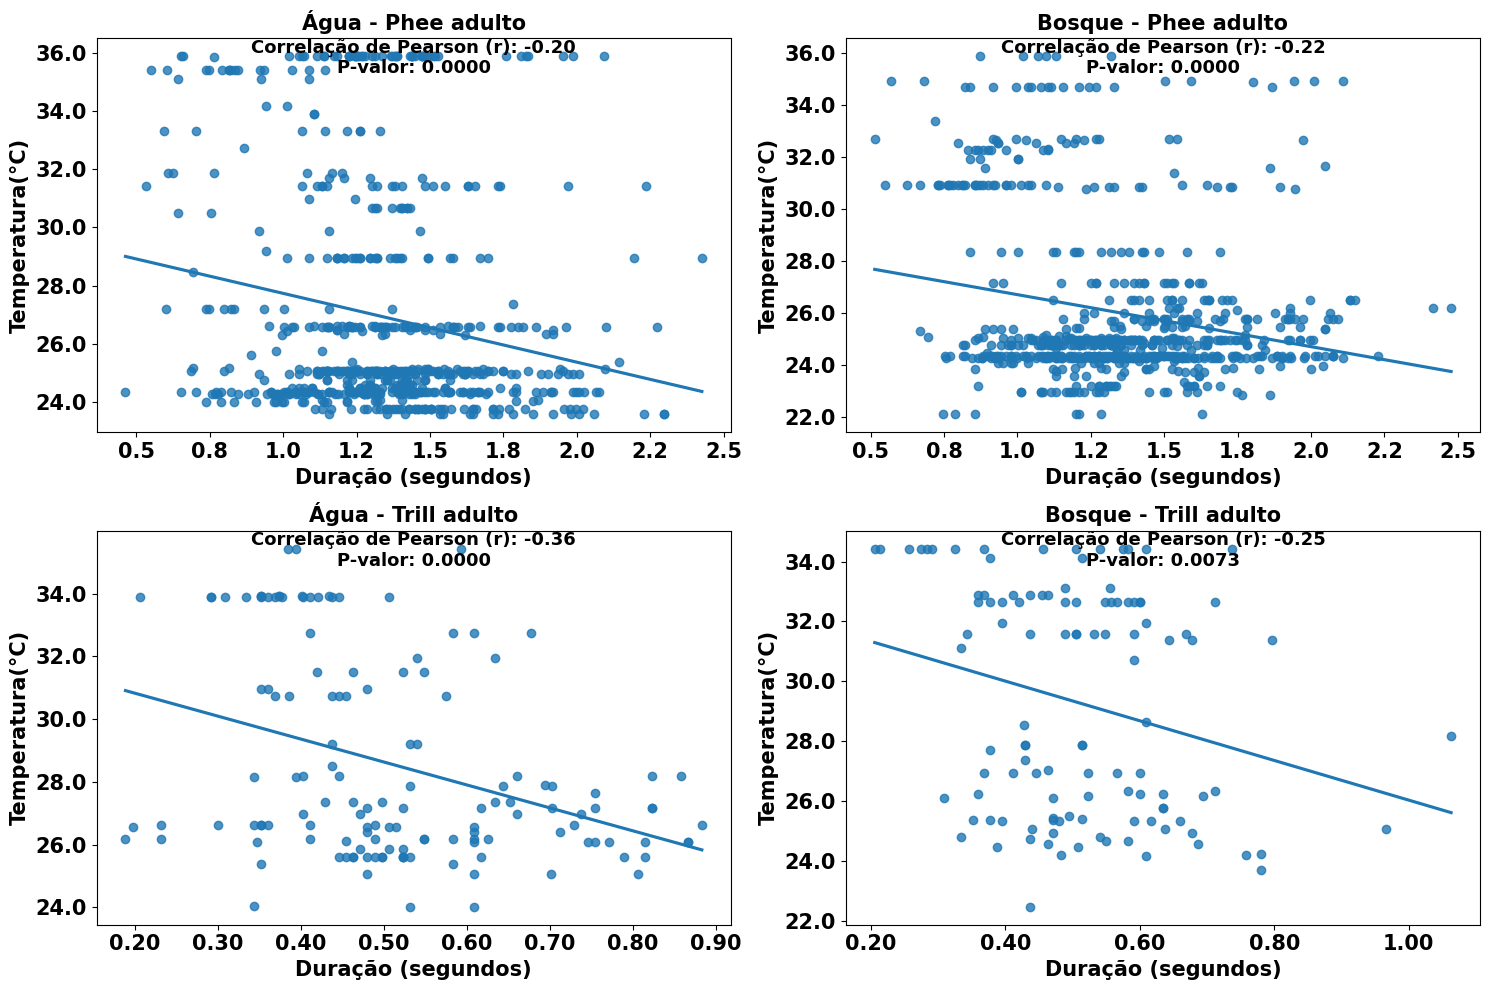

In [6]:
# Criar figura e eixos
from matplotlib.ticker import FormatStrFormatter
# Função para plotar regressão com R² e correlação de Pearson
def plot_regressao_com_r2_correlacao_pvalor(x, y, ax, grupo):
    valores_validos = (~pd.isnull(x)) & (~pd.isnull(y))
    inclinacao, intercepto, r_valor, p_valor, erro_padrao = linregress(x[valores_validos], y[valores_validos])
    
    # Plotando a regressão
    sns.regplot(x=x[valores_validos], y=y[valores_validos], ax=ax, line_kws={'label': f'Regressão (R²={r_valor**2:.2f})'}, ci=None)
    
    # Adicionando correlação de Pearson e p-valor ao gráfico
    corr, p_val = pearsonr(x[valores_validos], y[valores_validos])
    ax.text(0.5, 0.95, f'Correlação de Pearson (r): {corr:.2f}\nP-valor: {p_val:.4f}', ha='center', va='center', transform=ax.transAxes,weight="bold", fontsize=13)

    # Imprimindo o p-valor no console
    print(f'{grupo} - P-valor: {p_val}')
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Subplot 1: Regressão para Grupo Água - 'phee'
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua['Tempototal'],
    df_final_dia_agua['Temperatura'],
    axes[0, 0],
    'Água (phee)'
)

# Subplot 2: Regressão para Grupo Bosque - 'phee'
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque['Tempototal'],
    df_final_dia_bosque['Temperatura'],
    axes[0, 1],
    'Bosque (phee)'
)

# Subplot 3: Regressão para Grupo Água - 'trill'
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_agua_trill['Tempototal'],
    df_final_dia_agua_trill['Temperatura'],
    axes[1, 0],
    'Água (trill)'
)

# Subplot 4: Regressão para Grupo Bosque - 'trill'
plot_regressao_com_r2_correlacao_pvalor(
    df_final_dia_bosque_trill['Tempototal'],
    df_final_dia_bosque_trill['Temperatura'],
    axes[1, 1],
    'Bosque (trill)'
)

axes[0, 0].set_title(f'Água - Phee adulto', size=15, weight="bold")
axes[0, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 0].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[0, 0].set_xticklabels(axes[0, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[0, 0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='x', labelsize=15)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticks(), fontweight="bold")
axes[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 0].tick_params(axis='y', labelsize=15)
# axes[0, 0].set_ylim(26, 30)

axes[0, 1].set_title(f'Bosque - Phee adulto', size=15, weight="bold")
axes[0, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[0, 1].set_ylabel('Temperatura(°C)',  size=15, weight="bold")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticks(), fontweight="bold")
axes[0, 1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='x', labelsize=15)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticks(), fontweight="bold")
axes[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[0, 1].tick_params(axis='y', labelsize=15)
# axes[0, 1].set_ylim(26, 30)

axes[1, 0].set_title(f'Água - Trill adulto', size=15, weight="bold")
axes[1, 0].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 0].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='x', labelsize=15)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticks(), fontweight="bold")
axes[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 0].tick_params(axis='y', labelsize=15)
# axes[1, 0].set_ylim(26, 30)

axes[1, 1].set_title(f'Bosque - Trill adulto',size=15, weight="bold")
axes[1, 1].set_xlabel('Duração (segundos)', size=15, weight="bold")
axes[1, 1].set_ylabel('Temperatura(°C)', size=15, weight="bold")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticks(), fontsize=15, fontweight="bold")
axes[1, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='x', labelsize=15)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticks(), fontweight="bold")
axes[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Formato com uma casa decimal
axes[1, 1].tick_params(axis='y', labelsize=15)
# axes[1, 1].set_ylim(26, 30)




# Ajustar o layout
plt.tight_layout()
plt.savefig(r'G:\Meu Drive\Mestrado\Triagem dos dados\imagens\correlação_dia adulto temperatura.png', bbox_inches='tight')
plt.show()